In [1]:
import shutil

src = '/kaggle/input/krt-100/KRT_ResNet34.pth'
dst = '/kaggle/working/KRT_ResNet34.pth'

shutil.copy(src, dst)

'/kaggle/working/KRT_ResNet34.pth'

Using device: cuda


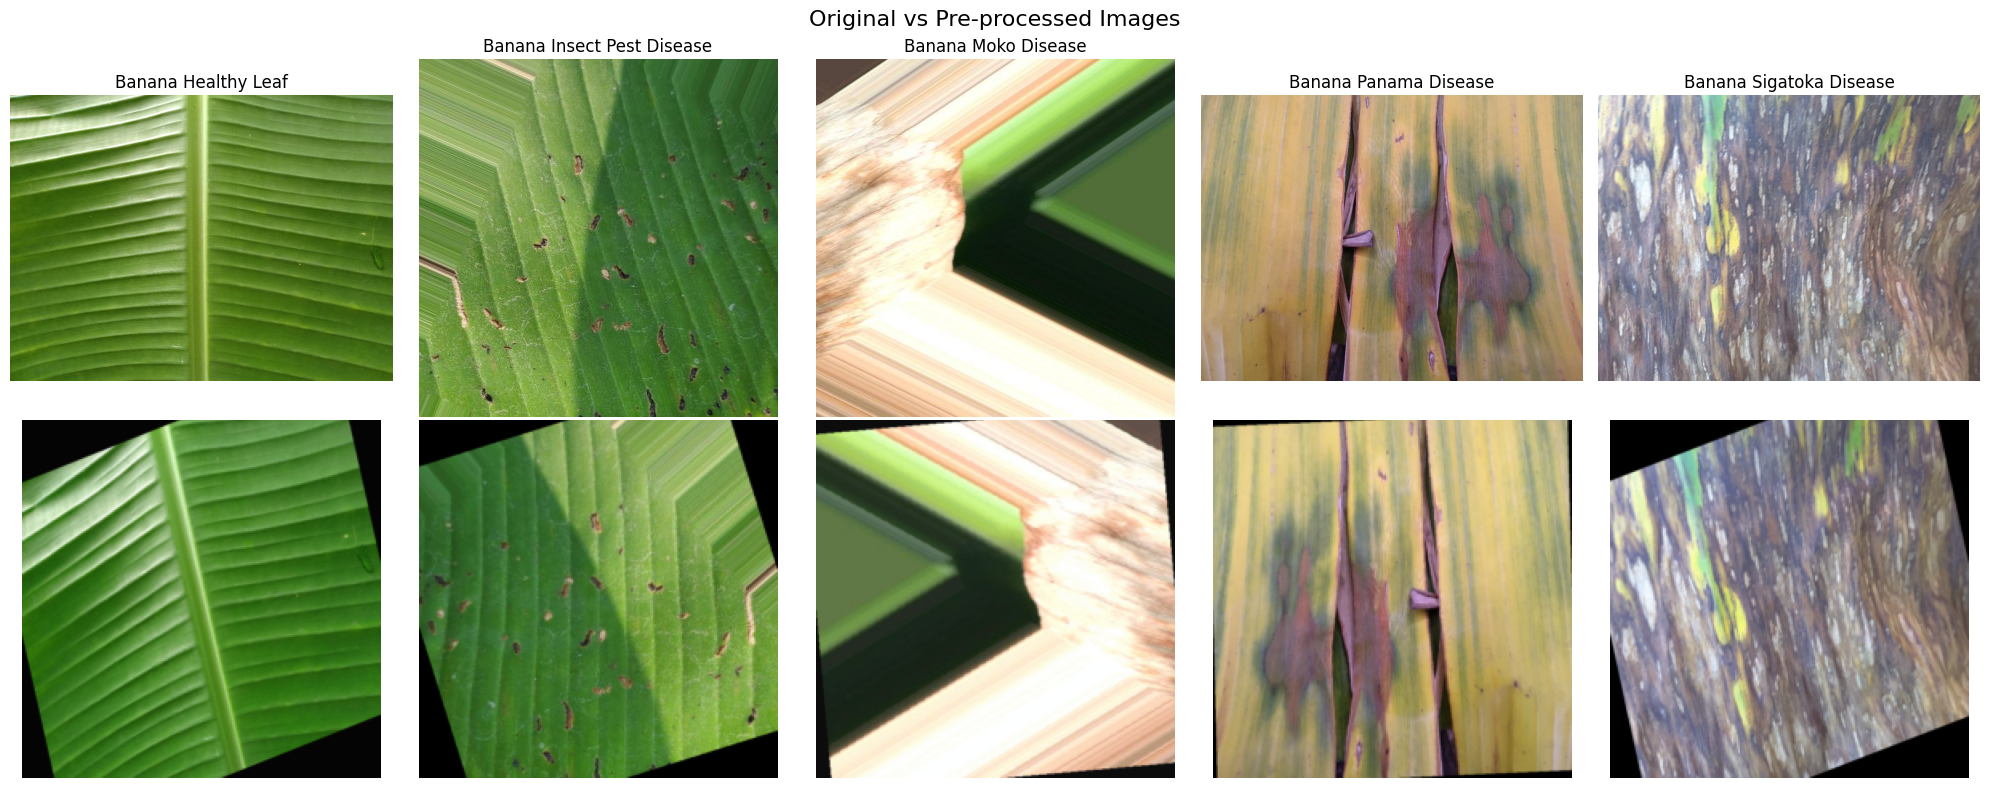

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 209MB/s]


Loading checkpoint /kaggle/working/KRT_ResNet34.pth
Epoch 76/100 — TLoss: 0.0075, TAcc: 99.72% | VLoss: 0.0180, VAcc: 99.43% | LR: 1.00e-08
Epoch time: 971.8s

Epoch 77/100 — TLoss: 0.0088, TAcc: 99.71% | VLoss: 0.0189, VAcc: 99.43% | LR: 1.00e-08
Epoch time: 956.0s

Epoch 78/100 — TLoss: 0.0079, TAcc: 99.63% | VLoss: 0.0173, VAcc: 99.49% | LR: 1.00e-08
Epoch time: 963.5s

Epoch 79/100 — TLoss: 0.0081, TAcc: 99.53% | VLoss: 0.0214, VAcc: 99.43% | LR: 1.00e-08
Epoch time: 957.1s

Epoch 80/100 — TLoss: 0.0096, TAcc: 99.72% | VLoss: 0.0179, VAcc: 99.49% | LR: 1.00e-08
Epoch time: 959.0s

Epoch 81/100 — TLoss: 0.0092, TAcc: 99.63% | VLoss: 0.0199, VAcc: 99.49% | LR: 1.00e-08
Epoch time: 960.6s

Epoch 82/100 — TLoss: 0.0072, TAcc: 99.75% | VLoss: 0.0186, VAcc: 99.49% | LR: 1.00e-08
Epoch time: 958.0s

Epoch 83/100 — TLoss: 0.0071, TAcc: 99.62% | VLoss: 0.0172, VAcc: 99.43% | LR: 1.00e-08
Epoch time: 957.0s

Epoch 84/100 — TLoss: 0.0072, TAcc: 99.70% | VLoss: 0.0184, VAcc: 99.49% | LR: 1.00e

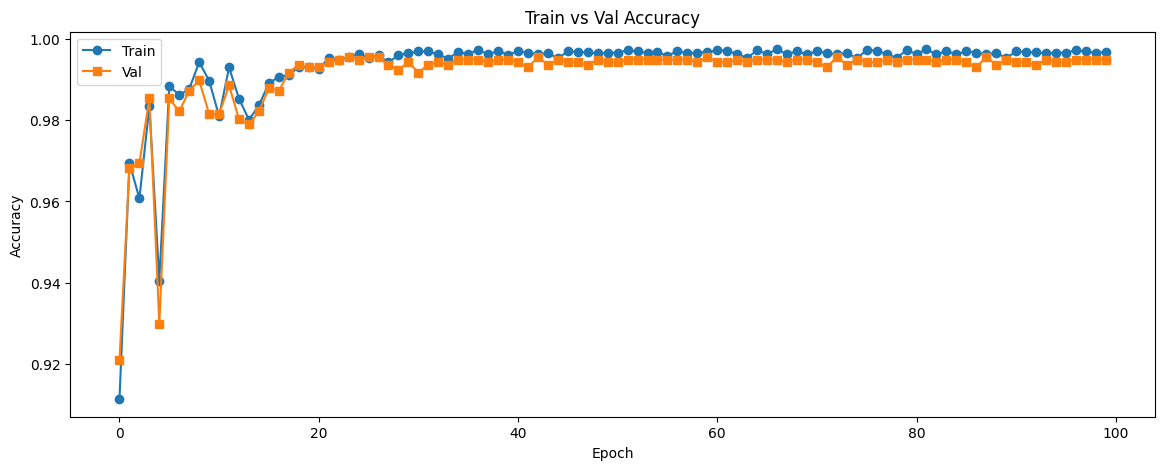

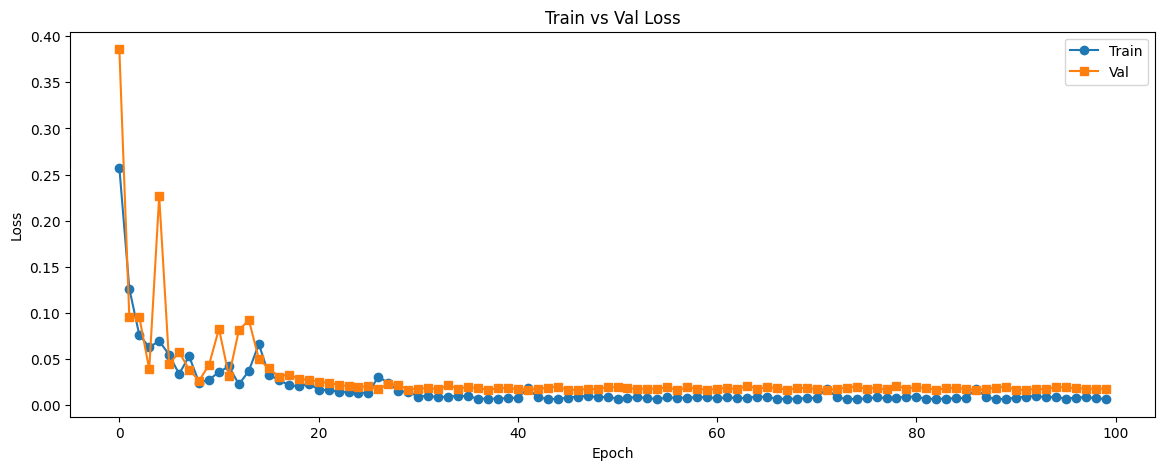

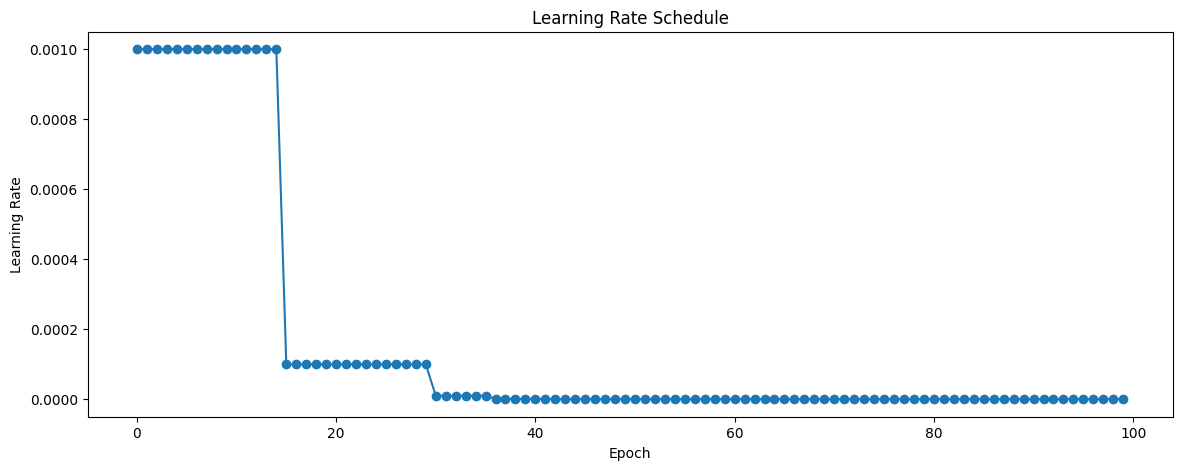

Best Confusion Matrix:


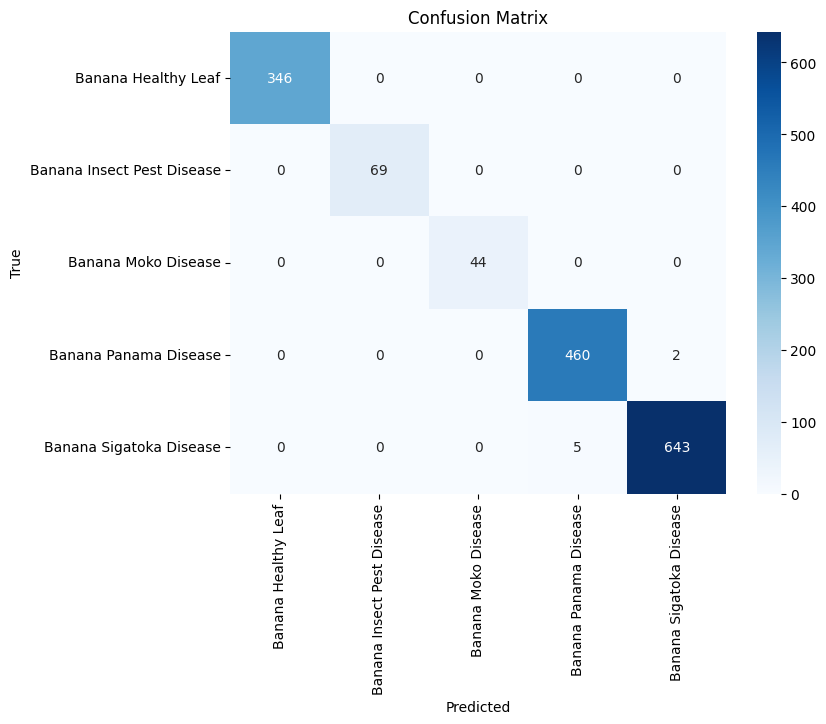

Loading best weights for final evaluation...

Overall — Acc: 99.55%, Prec: 99.56%, Rec: 99.55%, F1: 99.55%


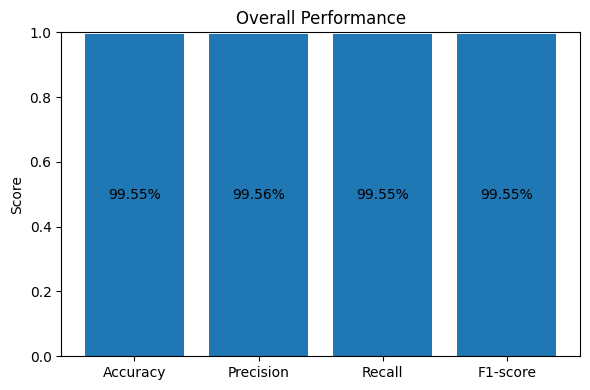

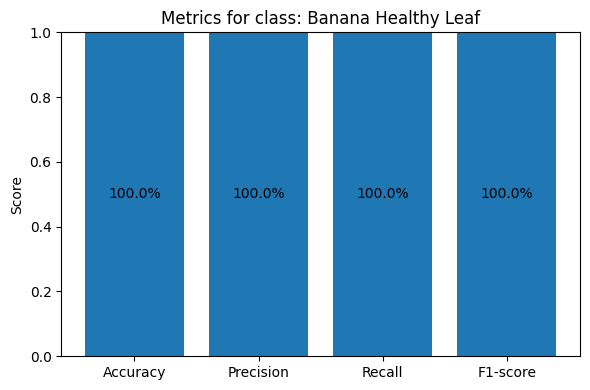

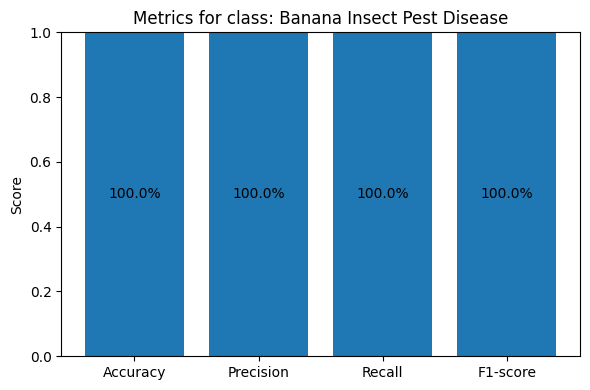

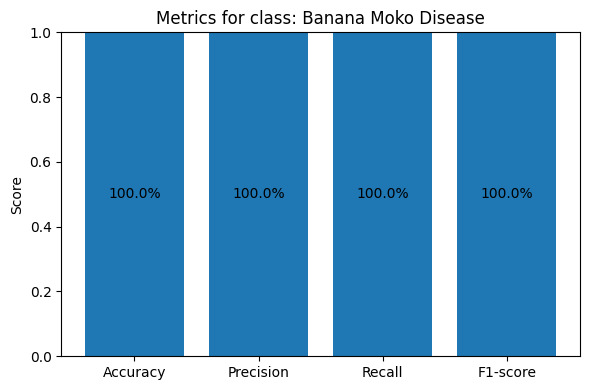

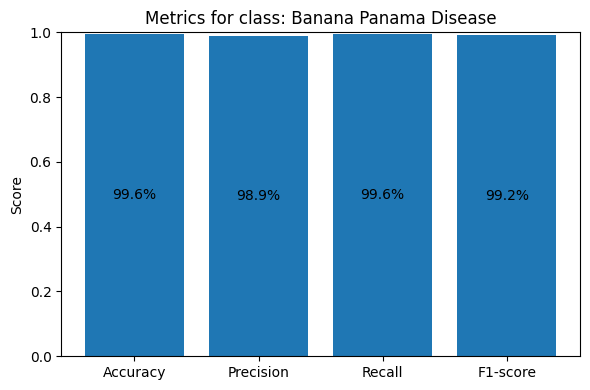

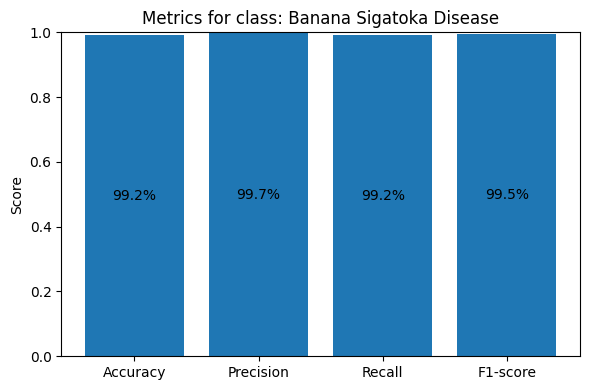

In [2]:
import os
import time
import random
import copy
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from torchvision.models import ResNet34_Weights
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix
)
from sklearn.utils.class_weight import compute_class_weight
from torch.amp import GradScaler, autocast

# === Paths Configuration ===
train_dir       = "/kaggle/input/34-bdlc/train"
val_dir         = "/kaggle/input/34-bdlc/val"
checkpoint_path = "/kaggle/working/KRT_ResNet34.pth"

# === Device & Seed ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# === Dataset with CLAHE ===
class BananaDiseaseDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = cv2.imread(self.image_paths[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = self._apply_clahe(img)
        if self.transform:
            img = self.transform(img)
        return img, self.labels[idx]

    def _apply_clahe(self, img):
        lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
        l, a, b = cv2.split(lab)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        cl = clahe.apply(l)
        merged = cv2.merge((cl, a, b))
        return cv2.cvtColor(merged, cv2.COLOR_Lab2RGB)

# === Transforms ===
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(0.1,0.1,0.1,0.05),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])
val_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

# === Helpers ===
def load_dataset(folder):
    paths, labels = [], []
    classes = sorted(d for d in os.listdir(folder) if os.path.isdir(os.path.join(folder, d)))
    for idx, cls in enumerate(classes):
        cls_folder = os.path.join(folder, cls)
        for f in os.listdir(cls_folder):
            if f.lower().endswith(('png','jpg','jpeg')):
                paths.append(os.path.join(cls_folder, f))
                labels.append(idx)
    return paths, labels, classes

def compute_train_accuracy(model, loader):
    model.eval()
    preds, labs = [], []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            with autocast(device_type=device.type):
                out = model(x)
            _, p = torch.max(out, 1)
            preds += p.cpu().tolist()
            labs  += y.cpu().tolist()
    model.train()
    return accuracy_score(labs, preds)

def validate_model(model, loader, criterion):
    model.eval()
    preds, labs = [], []
    loss_sum = 0.0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            with autocast(device_type=device.type):
                out = model(x)
                loss = criterion(out, y)
            loss_sum += loss.item()
            _, p = torch.max(out, 1)
            preds += p.cpu().tolist()
            labs  += y.cpu().tolist()
    cm  = confusion_matrix(labs, preds)
    acc = accuracy_score(labs, preds)
    model.train()
    return acc, (loss_sum/len(loader)), cm, preds, labs

def plot_curve(train_vals, val_vals, ylabel, title):
    plt.figure(figsize=(14,5))
    plt.plot(train_vals, marker='o')
    plt.plot(val_vals, marker='s')
    plt.xlabel('Epoch')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend(['Train','Val'])
    plt.show()

def plot_lr_curve(lrs):
    plt.figure(figsize=(14,5))
    plt.plot(lrs, marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.title('Learning Rate Schedule')
    plt.show()

def plot_confusion(cm, labels, cmap='Blues'):
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap,
                xticklabels=labels, yticklabels=labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

def plot_class_metrics(idx, class_name, acc_arr, prec_arr, rec_arr, f1_arr):
    metrics = ['Accuracy','Precision','Recall','F1-score']
    values  = [acc_arr[idx], prec_arr[idx], rec_arr[idx], f1_arr[idx]]
    plt.figure(figsize=(6,4))
    bars = plt.bar(metrics, values)
    plt.ylim(0, 1.0)
    plt.title(f"Metrics for class: {class_name}")
    plt.ylabel("Score")
    for bar, val in zip(bars, values):
        plt.text(bar.get_x() + bar.get_width()/2, val * 0.5,
                 f"{val*100:.1f}%", ha='center', va='center')
    plt.tight_layout()
    plt.show()

def display_original_and_preprocessed_images(image_paths, labels, transform, class_names):
    num_classes = len(class_names)
    fig, axes = plt.subplots(2, num_classes, figsize=(4*num_classes,8))
    fig.suptitle("Original vs Pre-processed Images", fontsize=16)
    for i, cls in enumerate(class_names):
        idx = next((j for j,lbl in enumerate(labels) if lbl==i), None)
        if idx is None: continue
        orig = cv2.cvtColor(cv2.imread(image_paths[idx]), cv2.COLOR_BGR2RGB)
        proc = transform(orig.copy()).permute(1,2,0).numpy()
        proc = proc * np.array([0.229,0.224,0.225]) + np.array([0.485,0.456,0.406])
        proc = np.clip(proc, 0, 1)
        axes[0,i].imshow(orig); axes[0,i].axis('off'); axes[0,i].set_title(cls)
        axes[1,i].imshow(proc); axes[1,i].axis('off')
    plt.tight_layout()
    plt.show()

def plot_overall_metrics(acc, prec, rec, f1):
    metrics = ['Accuracy','Precision','Recall','F1-score']
    values = [acc, prec, rec, f1]
    plt.figure(figsize=(6,4))
    bars = plt.bar(metrics, values)
    plt.ylim(0,1.0)
    plt.title('Overall Performance')
    for bar, val in zip(bars, values):
        plt.text(bar.get_x()+bar.get_width()/2, val*0.5,
                 f"{val*100:.2f}%", ha='center', va='center')
    plt.ylabel('Score')
    plt.tight_layout()
    plt.show()

# === Main ===
def main():
    # Load data
    train_paths, train_labels, class_names = load_dataset(train_dir)
    val_paths, val_labels, _ = load_dataset(val_dir)

    # Visualize
    display_original_and_preprocessed_images(
        train_paths, train_labels, train_transform, class_names
    )

    # Dataloaders
    train_loader = DataLoader(
        BananaDiseaseDataset(train_paths, train_labels, train_transform),
        batch_size=128, shuffle=True, num_workers=4, pin_memory=True
    )
    val_loader = DataLoader(
        BananaDiseaseDataset(val_paths, val_labels, val_transform),
        batch_size=128, shuffle=False, num_workers=4, pin_memory=True
    )

    # Class weights
    cw = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
    cw = torch.tensor(cw, dtype=torch.float).to(device)

    # Model with new weights API
    model = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)
    in_f = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Dropout(0.3),
        nn.Linear(in_f, len(class_names))
    )
    for p in model.parameters(): p.requires_grad = False
    for p in model.layer3.parameters(): p.requires_grad = True
    for p in model.layer4.parameters(): p.requires_grad = True
    for p in model.fc.parameters():    p.requires_grad = True
    model.to(device)


    criterion = nn.CrossEntropyLoss(weight=cw)
    optimizer = optim.AdamW(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=1e-3, weight_decay=1e-4
    )
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', factor=0.1, patience=5)
    scaler = GradScaler()

    # Resume if checkpoint exists
    start_epoch, best_accuracy = 0, 0.0
    all_train_accs, all_val_accs = [], []
    all_train_losses, all_val_losses = [], []
    all_lrs, total_time = [], 0.0
    best_wts, best_cm = None, None

    if os.path.isfile(checkpoint_path):
        print(f"Loading checkpoint {checkpoint_path}")
        ckpt = torch.load(checkpoint_path, map_location=device,weights_only=False)
        model.load_state_dict(ckpt['model_state'])
        optimizer.load_state_dict(ckpt['optimizer_state'])
        scheduler.load_state_dict(ckpt['scheduler_state'])
        scaler.load_state_dict(ckpt['scaler_state'])
        start_epoch = ckpt['epoch'] + 1
        best_accuracy = ckpt['best_accuracy']
        best_cm = ckpt['best_cm']
        best_wts = ckpt['best_wts']
        all_train_accs = ckpt['train_accs']
        all_val_accs = ckpt['val_accs']
        all_train_losses = ckpt['train_losses']
        all_val_losses = ckpt['val_losses']
        all_lrs = ckpt['lrs']
        total_time = ckpt.get('total_elapsed', 0.0)

    # Training loop
    num_epochs = 100
    for epoch in range(start_epoch, num_epochs):
        t0 = time.time()
        model.train()
        running_loss = 0.0

        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            with autocast(device_type=device.type):
                out = model(x)
                loss = criterion(out, y)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        train_acc = compute_train_accuracy(model, train_loader)
        all_train_losses.append(train_loss)
        all_train_accs.append(train_acc)
        all_lrs.append(optimizer.param_groups[0]['lr'])

        val_acc, val_loss, cm, _, _ = validate_model(model, val_loader, criterion)
        all_val_losses.append(val_loss)
        all_val_accs.append(val_acc)

        print(f"Epoch {epoch+1}/{num_epochs} — "
              f"TLoss: {train_loss:.4f}, TAcc: {train_acc*100:.2f}% | "
              f"VLoss: {val_loss:.4f}, VAcc: {val_acc*100:.2f}% | "
              f"LR: {optimizer.param_groups[0]['lr']:.2e}")

        scheduler.step(val_acc)
        if val_acc > best_accuracy:
            best_accuracy = val_acc
            best_cm = cm
            best_wts = copy.deepcopy(model.state_dict())

        epoch_time = time.time() - t0
        total_time += epoch_time

        # Save checkpoint
        torch.save({
            'epoch': epoch,
            'model_state': model.state_dict(),
            'optimizer_state': optimizer.state_dict(),
            'scheduler_state': scheduler.state_dict(),
            'scaler_state': scaler.state_dict(),
            'best_accuracy': best_accuracy,
            'best_cm': best_cm,
            'best_wts': best_wts,
            'train_accs': all_train_accs,
            'val_accs': all_val_accs,
            'train_losses': all_train_losses,
            'val_losses': all_val_losses,
            'lrs': all_lrs,
            'total_elapsed': total_time
        }, checkpoint_path)

        print(f"Epoch time: {epoch_time:.1f}s\n")

    # Final diagnostics & plots
    h, rem = divmod(total_time, 3600)
    m, s = divmod(rem, 60)
    print(f"Done in {int(h)}h {int(m)}m {int(s)}s. Best VAcc: {best_accuracy*100:.2f}%")

    plot_curve(all_train_accs, all_val_accs, 'Accuracy', 'Train vs Val Accuracy')
    plot_curve(all_train_losses, all_val_losses, 'Loss', 'Train vs Val Loss')
    plot_lr_curve(all_lrs)
    print("Best Confusion Matrix:"); plot_confusion(best_cm, class_names)
    print("Loading best weights for final evaluation...")
    model.load_state_dict(best_wts)
    model.eval()
    _, _, _, final_preds, final_labels = validate_model(model, val_loader, criterion)

    o_acc  = accuracy_score(final_labels, final_preds)
    o_prec = precision_score(final_labels, final_preds, average='weighted')
    o_rec  = recall_score(final_labels, final_preds, average='weighted')
    o_f1   = f1_score(final_labels, final_preds, average='weighted')

    print(f"\nOverall — Acc: {o_acc*100:.2f}%, Prec: {o_prec*100:.2f}%, "
          f"Rec: {o_rec*100:.2f}%, F1: {o_f1*100:.2f}%")
    plot_overall_metrics(o_acc, o_prec, o_rec, o_f1)

    per_prec = precision_score(final_labels, final_preds, average=None)
    per_rec  = recall_score(final_labels, final_preds, average=None)
    per_f1   = f1_score(final_labels, final_preds, average=None)
    per_acc  = best_cm.diagonal() / best_cm.sum(axis=1)
    for idx, cls in enumerate(class_names):
        plot_class_metrics(idx, cls, per_acc, per_prec, per_rec, per_f1)

if __name__ == '__main__':
    main()
